In [127]:
import torch
from torch import nn
from torch.nn import functional as F

import numpy as np
import matplotlib.pyplot as plt

In [142]:
import seaborn as sns

sns.set_theme(style="dark")#, palette="Set2")

# Load data

In [143]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

batch_size = 128

dataset, _ = make_blobs(n_samples=1024, centers=4, n_features=2, random_state=42)


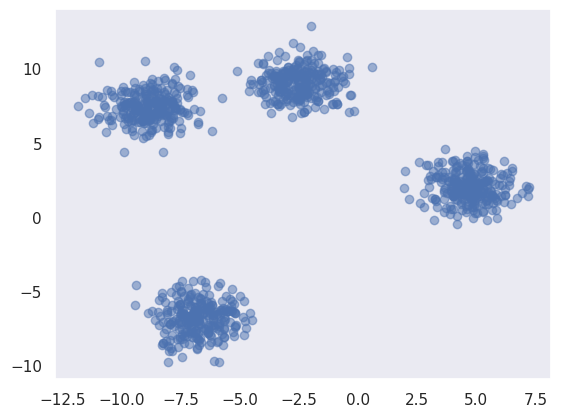

In [144]:
plt.scatter(dataset[:, 0], dataset[:, 1], alpha=0.5)
plt.show()
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=42)

X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()

tensor_dataset = TensorDataset(X_train)
dataloader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

tensor_dataset_test = TensorDataset(X_test)
dataloader_test = DataLoader(tensor_dataset_test, batch_size=batch_size, shuffle=False, drop_last=False)


# Model

In [145]:
class ScoreModel(nn.Module):
    def __init__(self, n_features, n_hidden, sigma_hidden=8):
        super().__init__()
        self.s_emb = nn.Sequential(
            nn.Linear(1, sigma_hidden),
            nn.SiLU(),
            nn.Linear(sigma_hidden, sigma_hidden),
        )

        self.net = nn.Sequential(
            nn.Linear(n_features + sigma_hidden, n_hidden),
            nn.SiLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.SiLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.SiLU(),
            nn.Linear(n_hidden, n_features),
        )

    def forward(self, x, sigma):
        s = self.s_emb(torch.log(sigma))
        inp = torch.cat([x, s], dim=-1)
        score = self.net(inp)
        return score

In [146]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ScoreModel(n_features=2, n_hidden=128, sigma_hidden=8).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [147]:
sigma_min = 0.01
sigma_max = 10
sigma_log_min = np.log(sigma_min)
sigma_log_max = np.log(sigma_max)


In [148]:
def sample_sigma(batch_size, device):
    u = torch.rand(batch_size, device=device) * (sigma_log_max - sigma_log_min) + sigma_log_min
    sigma = torch.exp(u)
    return sigma.unsqueeze(1)

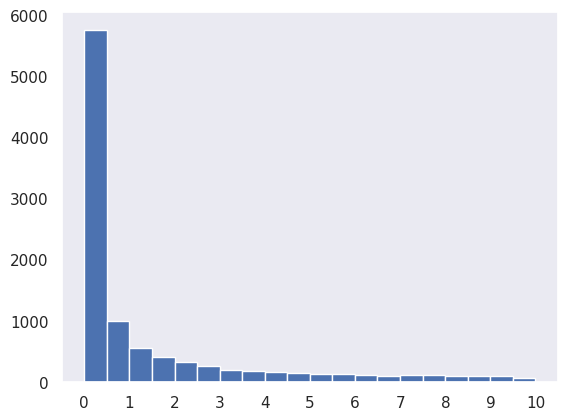

In [149]:
plt.hist(sample_sigma(10000, device).cpu().numpy(), bins=20)
plt.xticks(range(0, 11))
plt.show()

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

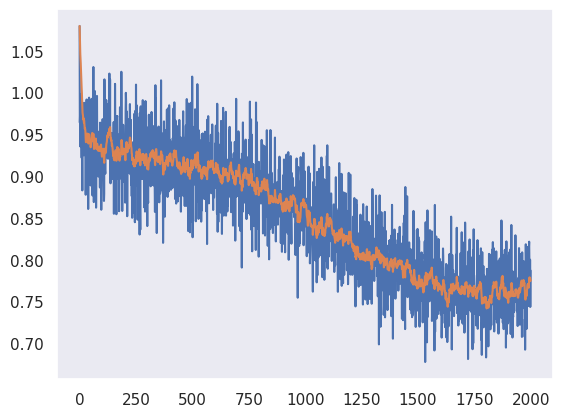

In [150]:
from tqdm.auto import tqdm

num_epochs = 200
loss_history = []

for pert in np.linspace(np.sqrt(5), 0, 10)**2:
    pbar = tqdm(range(num_epochs))
    for epoch in pbar:
        total_loss = 0.0
        for (x_batch,) in dataloader:
            x = x_batch.to(device)
            # pertubation
            x = x + torch.tensor(pert).to(device) * torch.randn_like(x).to(device)
            B = x.shape[0]
            sigma = sample_sigma(B, device)
            eps = torch.randn_like(x)
            x_noised = x + eps * sigma
            x_noised = x_noised.to(device)
            optimizer.zero_grad()
            score = model(x_noised, sigma)
            loss = F.mse_loss(score * sigma, -eps)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)
        pbar.set_description(f"Epoch {epoch+1:03d}/{num_epochs}, Loss: {avg_loss:.2f}")

plt.plot(loss_history)
ema_loss_history = [loss_history[0]]
for i in range(1, len(loss_history)):
    ema_loss_history.append(ema_loss_history[-1] * 0.9 + loss_history[i] * 0.1)
plt.plot(ema_loss_history)
plt.show()


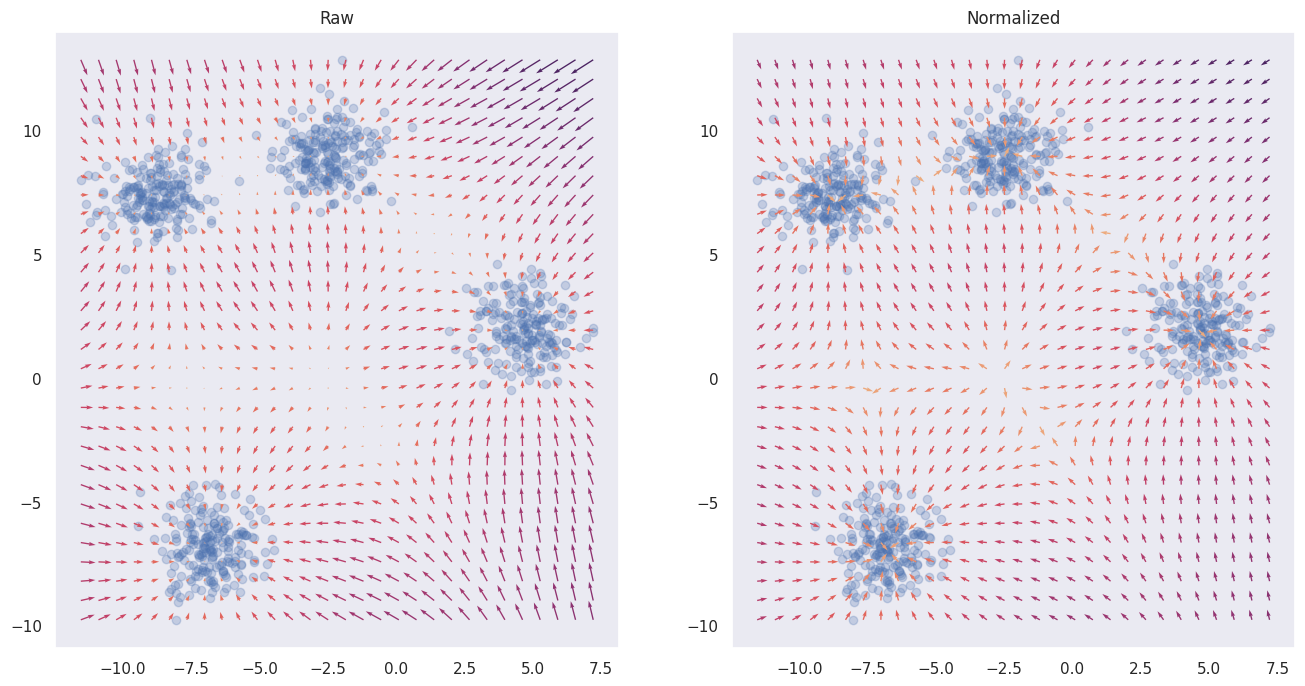

In [161]:
resolution = 30

# make a grid of points
x_min, x_max = X_train[:, 0].min(), X_train[:, 0].max()
y_min, y_max = X_train[:, 1].min(), X_train[:, 1].max()
X_mesh, y_mesh = torch.meshgrid(torch.linspace(x_min, x_max, resolution), torch.linspace(y_min, y_max, resolution))
plane = torch.stack([X_mesh, y_mesh], dim=-1)
plane.shape

with torch.no_grad():
    plane_flat = plane.reshape(-1, 2).to(device)
    sigma = torch.ones(plane_flat.shape[0], 1).to(device) #* sigma_min
    score = model(plane_flat, sigma).cpu().numpy()
    norms = np.linalg.norm(score, axis=-1, keepdims=True)
    score_normed = score / norms
    score_x = score[:, 0].reshape(resolution, resolution)
    score_y = score[:, 1].reshape(resolution, resolution)
    score_x_normed = score_normed[:, 0].reshape(resolution, resolution)
    score_y_normed = score_normed[:, 1].reshape(resolution, resolution)

scaler = plt.Normalize(vmin=0, vmax=norms.max(), clip=True)
# cmap = plt.cm.inferno
cmap = sns.color_palette("flare", as_cmap=True)
colors = cmap(scaler(norms))
colors_normed = cmap(scaler(norms))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.set_title("Raw")
ax1.scatter(X_train[:, 0], X_train[:, 1], alpha=0.25)
ax1.quiver(X_mesh, y_mesh, score_x, score_y, color=colors)
ax2.set_title("Normalized")
ax2.scatter(X_train[:, 0], X_train[:, 1], alpha=0.25)
ax2.quiver(X_mesh, y_mesh, score_x_normed, score_y_normed, color=colors_normed)
fig.show(warn=False)